# Using the trained multi-channel model
Added by Shooby on Oct 30th <br>

In [100]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np

device = torch.device("cpu") # If GPU then use "cuda:0"
ngf = 64
workers = 4 #number of data loading workers
batchSize = 64 #input batch size
imageSize = 64 #the height / width of the input image to network
ngc = 7

In [104]:
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom

hi_psfs = ['psf_b.fits','psf_v.fits', 'psf_i.fits','psf_i.fits', 'psf_z.fits', 'psf_j.fits', 'psf_h.fits']
lo_psfs = ['PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits',
           'PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits']

kernel = np.zeros((1,ngc,20,20))
for i in range(len(hi_psfs)):
    psf = pyfits.getdata('../psfs/'+hi_psfs[i])
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[8:-8,8:-8]#[22:-22,22:-22]

    psf_hsc = pyfits.getdata('../psfs/'+lo_psfs[i])
    psf_hsc = psf_hsc[2:42,2:42]
    a = create_matching_kernel(psf,psf_hsc)
    kernel[0,i,:,:] = a[10:-10,10:-10]

kernel = torch.Tensor(kernel)
kernel =  kernel.float()

In [68]:
# skip this cell is old
psf = pyfits.getdata('../psfs/psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]
print(psf.shape)

psf_hsc = pyfits.getdata('../psfs/PSF_subaru_i.fits')
psf_hsc = psf_hsc[0:41,0:41]
#psf_hsc = zoom(psf_hsc, 3, order=1)
print(psf_hsc.shape)

kern = create_matching_kernel(psf,psf_hsc)
print(kern.shape)

psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()
print(kernel.shape)


(41, 41)
(41, 41)
(41, 41)
torch.Size([1, 1, 41, 41])


In [106]:
class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(ngc, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 8, 3, 3, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 7, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            
            nn.ConvTranspose2d(ngf*4, ngc, 4, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

netS = Shoobygen(1).to(device)
netS.load_state_dict(torch.load('../trained_weights/netG_epoch_997.pth',map_location='cpu'))


<All keys matched successfully>

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

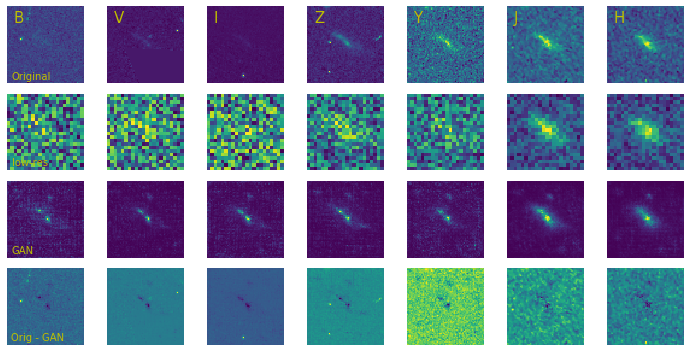

In [161]:
from galaxy_hdf5loader import galaxydata
dataset = galaxydata('../Sample.hdf5')
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=True, num_workers=int(4))
inputs, classes = next(iter(dataloader))  
real_cpu = inputs.to('cpu')
ajab = real_cpu.detach()
ajab2 = ajab.cpu()

labels = ['B','V','I','Z','Y','J','H']
plt.figure(figsize=(10,5))
for i in range(7):
    plt.subplot(4,7,i+1)
    plt.imshow(ajab2[0,i,:,:],origin='lower')
    plt.text(5,50,labels[i],color='y',size=15)
    plt.axis('off')

       
kernel = kernel.to(device)
img2 = torch.tensor(np.zeros((1,ngc,22,22)))
for ch in range(real_cpu.shape[1]):
    imagetoconvolv = real_cpu[:,ch,:,:].reshape(-1,1,64,64)
    kerneltoconvolv = kernel[:,ch,:,:].reshape(-1,1,20,20)
            
    a = F.conv2d(imagetoconvolv, kerneltoconvolv).data.squeeze()
    a = a.reshape(-1,1,45,45)
    downsampled = F.upsample(a,scale_factor=1/2,mode='bilinear')
    img2[:,ch,...] = downsampled[:,0,:,:]
            
            
img = img2.view(-1,ngc,22,22)
img = img+0.25*torch.rand_like(img)
img = img[:,:,:,:].float()


for i in range(7):
    plt.subplot(4,7,7+i+1)
    plt.imshow(img[0,i,:,:],origin='lower')
    plt.axis('off')
    
fake = netS(img)
fd = fake.detach()

for i in range(7):
    plt.subplot(4,7,14+i+1)
    plt.imshow(fd[0,i,:,:],origin='lower')
    plt.axis('off')
    
for i in range(7):
    plt.subplot(4,7,21+i+1)
    plt.imshow(ajab2[0,i,:,:]-fd[0,i,:,:],origin='lower')
    plt.axis('off')
    
plt.subplot(4,7,1)
plt.text(3,3,'Original',color='y')
plt.subplot(4,7,8)
plt.text(1,1,'low-res',color='y')
plt.subplot(4,7,15)
plt.text(3,3,'GAN',color='y')
plt.subplot(4,7,22)
plt.text(3,3,'Orig - GAN',color='y')


plt.tight_layout()